<a href="https://colab.research.google.com/github/VPA2998/ACC_pid/blob/main/Machine_Learning_Based_AEB_Project_with_MetaDrive_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚗 Machine Learning Based AEB Project with MetaDrive Simulator
This notebook records a dataset for **Automatic Emergency Braking (AEB)** using MetaDrive,
trains both **classification** (Brake flag) and **regression** (Brake value) ML models, evaluates them,
and visualizes model predictions in Colab.

**Steps covered:**
1. Collect dataset from MetaDrive simulation (ego speed, rel speed, distance, brake_flag, brake_value).
2. Train multiple classification models and regression models.
3. Evaluate models with metrics (classification report, confusion matrix, regression R²/MSE).
4. Visualize predictions from trained models.

In [ ]:
%pip install git+https://github.com/metadriverse/metadrive.git

  Cloning https://github.com/metadriverse/metadrive.git to /tmp/pip-req-build-wuwrew1t
  Running command git clone --filter=blob:none --quiet https://github.com/metadriverse/metadrive.git /tmp/pip-req-build-wuwrew1t
  Resolved https://github.com/metadriverse/metadrive.git to commit 85e5dadc6c7436d324348f6e3d8f8e680c06b4db
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.9 MB/s eta 0:00:00
  Created wheel for metadrive-simulator: filename=metadrive_simulator-0.4.3-py3-none-any.whl size=55042153 sha256=8615a161ab4f0ed79e60e27f85d3cc678e85c32feb4354d4d43c016a34aeb521
  Stored in directory

In [ ]:
!pip install -q scikit-learn matplotlib seaborn pandas
!pip install -q gradio joblib pillow imageio


In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from metadrive import MetaDriveEnv

In [ ]:
config = {
    "use_render": False,
    "accident_prob": 0.5,
    "traffic_density": 0.25,
    "num_scenarios": 500,   # allow at least 100 different maps
    "start_seed": 0
}
env = MetaDriveEnv(config)


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 1000


In [ ]:
def collect_data_with_frames(env, num_episodes=1, steps_per_ep=200):
    rows = []
    all_frames = []   # store frames for visualization later

    for ep in range(num_episodes):
        # Use ep as seed to ensure different but reproducible scenario
        obs, info = env.reset(seed=ep)
        ep_frames = []

        for step in range(steps_per_ep):
            action = [0.0, 0.8, 0.0]  # steer, throttle, brake
            obs, reward, terminated, truncated, info = env.step(action)

            # Render & save numpy image (top-down view)
            frame = env.render(mode="top_down", screen_size=(500, 500))
            ep_frames.append(frame)

            # --- Ego vehicle ---
            ego = env.agent
            ego_speed = np.linalg.norm(ego.speed)
            ego_pos = ego.position
            ego_lane = ego.lane_index

            # --- Find nearest lead vehicle in same lane ---
            min_dist, lead_speed = np.inf, 0.0
            for v in env.engine.traffic_manager.vehicles:
                if v.id == ego.id:
                    continue
                if v.lane_index != ego_lane:
                    continue
                dx, dy = v.position - ego_pos
                if dx > 0:  # ahead only
                    dist = np.linalg.norm([dx, dy])
                    if dist < min_dist:
                        min_dist = dist
                        lead_speed = np.linalg.norm(v.speed)

            # --- Record only if we found a lead vehicle ---
            if min_dist < np.inf:
                rel_speed = ego_speed - lead_speed
                ttc = min_dist / max(1e-3, rel_speed) if rel_speed > 0 else np.inf
                brake_flag = int((min_dist < 10) or (ttc < 2))

                # NCAP-style brake value
                max_decel = 6.8
                req_decel = (rel_speed**2)/(2*min_dist) if rel_speed > 0 else 0
                brake_value = min(1.0, req_decel/max_decel)

                rows.append([
                    ep, step, ego_speed, rel_speed, min_dist, ttc, brake_flag, brake_value
                ])

            if terminated or truncated:
                break

        all_frames.append(ep_frames)

    df = pd.DataFrame(
        rows,
        columns=["episode","step","ego_speed","rel_speed","distance","ttc","brake_flag","brake_value"]
    )
    return df, all_frames

# Collect multiple episodes
df, frames = collect_data_with_frames(env, num_episodes=150, steps_per_ep=150)
print("Dataset:", df.shape)
df.head()


[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 500


Dataset: (959, 8)


,episode,step,ego_speed,rel_speed,distance,ttc,brake_flag,brake_value
0,0,60,15.028997,11.692200,13.298325,1.137367,1,0.755887
1,0,61,15.275370,11.770532,12.136934,1.031129,1,0.839352
2,0,62,15.521742,11.849253,10.972048,0.925970,1,0.940926
3,0,63,15.768114,11.928665,9.805618,0.822021,1,1.000000
4,0,64,16.014488,12.009097,8.640750,0.719517,1,1.000000


✅ Episode 40 saved as episode25_metadrive.gif


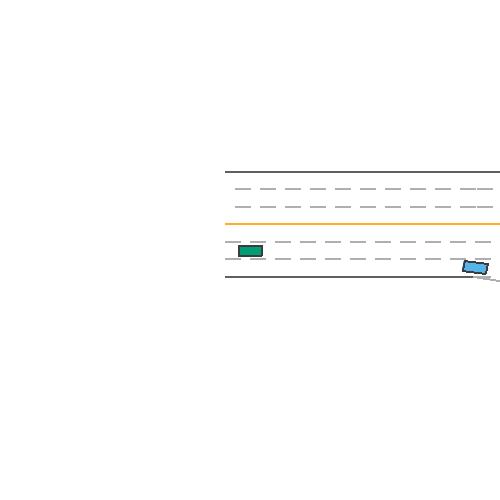

In [ ]:
def save_episode_with_metadrive(env, ep_idx=0, steps=200, filename="episode.gif"):
    """
    Replay one episode in MetaDrive and save a GIF using its built-in renderer.
    NOTE: This regenerates the episode using the given seed.
    """
    # Reset with reproducible seed
    try:
        obs, info = env.reset(seed=ep_idx)   # Gymnasium-style API
    except TypeError:
        env.seed(ep_idx)                     # fallback for older API
        obs, info = env.reset()

    for step in range(steps):
        action = [0.0, 0.8, 0.0]  # [steer, throttle, brake]
        obs, reward, terminated, truncated, info = env.step(action)

        # Record frames into MetaDrive's renderer
        env.render(mode="top_down", screen_record=True, screen_size=(500, 500))

        if terminated or truncated:
            break

    # ✅ Correct usage: pass only positional filename
    env.top_down_renderer.generate_gif(filename)
    print(f"✅ Episode {ep_idx} saved as {filename}")
    return filename

# Example usage
gif_file = save_episode_with_metadrive(env, ep_idx=40, steps=150, filename="episode25_metadrive.gif")

from IPython.display import Image as IPyImage
IPyImage(open(gif_file, "rb").read())


In [ ]:
df['brake_flag'].value_counts()
#df['brake_value'].var()   # variance
#df['brake_value'].std()   # standard deviation
#df['brake_value'].mean()


,count
brake_flag,
1,584
0,375


Xc_train shape: (767, 3)
Xc_test shape: (192, 3)
yc_train shape: (767,)
yc_test shape: (192,)
--- LogReg ---
              precision    recall  f1-score   support

           0       0.92      0.93      0.93        75
           1       0.96      0.95      0.95       117

    accuracy                           0.94       192
   macro avg       0.94      0.94      0.94       192
weighted avg       0.94      0.94      0.94       192



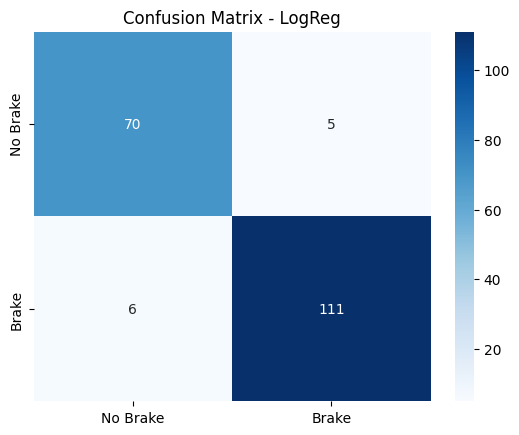

--- SVM ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        75
           1       0.98      0.98      0.98       117

    accuracy                           0.98       192
   macro avg       0.98      0.98      0.98       192
weighted avg       0.98      0.98      0.98       192



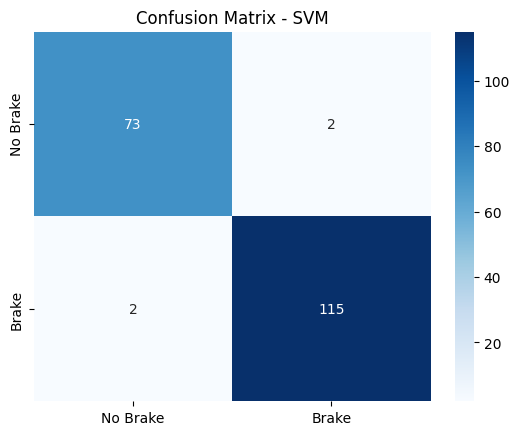

--- RF ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        75
           1       0.98      0.99      0.99       117

    accuracy                           0.98       192
   macro avg       0.98      0.98      0.98       192
weighted avg       0.98      0.98      0.98       192



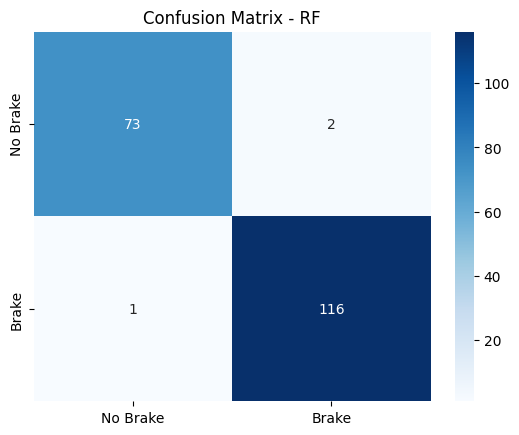

In [ ]:
# Classification models
Xc = df[['ego_speed','rel_speed','distance']]
yc = df['brake_flag']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)
print("Xc_train shape:", Xc_train.shape)
print("Xc_test shape:", Xc_test.shape)
print("yc_train shape:", yc_train.shape)
print("yc_test shape:", yc_test.shape)


class_models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'RF': RandomForestClassifier(n_estimators=200, random_state=42)
}

for name, model in class_models.items():
    model.fit(Xc_train, yc_train)
    y_pred = model.predict(Xc_test)
    print(f'--- {name} ---')
    print(classification_report(yc_test, y_pred))
    cm = confusion_matrix(yc_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Brake','Brake'], yticklabels=['No Brake','Brake'])
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

--- LinReg ---
MSE: 0.0144, R²: 0.8842


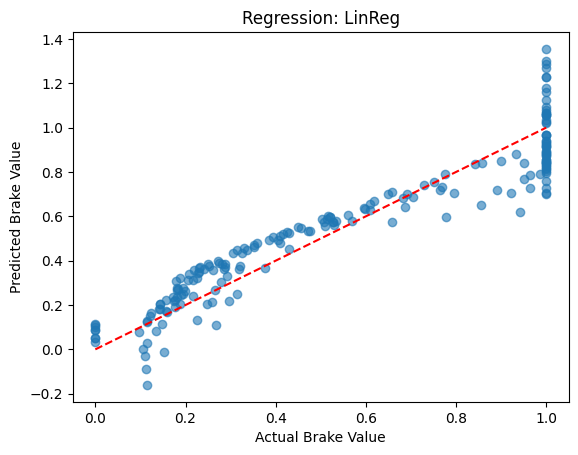

--- SVR ---
MSE: 0.0034, R²: 0.9726


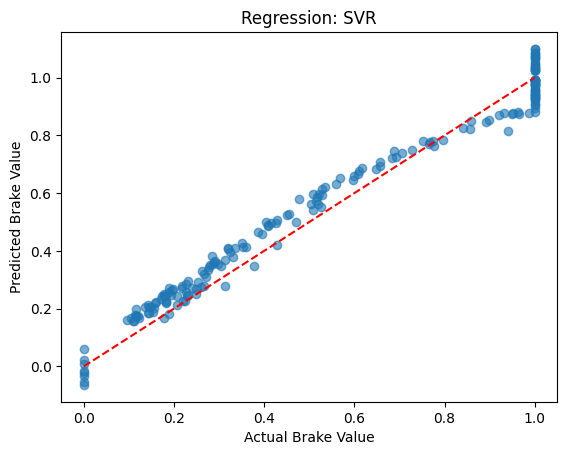

--- RF_Reg ---
MSE: 0.0006, R²: 0.9956


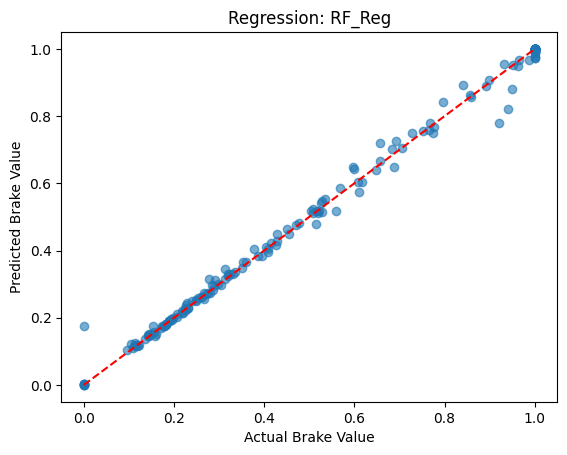

In [ ]:
# Regression models
Xr = df[['ego_speed','rel_speed','distance']]
yr = df['brake_value']
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

reg_models = {
    'LinReg': LinearRegression(),
    'SVR': SVR(),
    'RF_Reg': RandomForestRegressor(n_estimators=200, random_state=42)
}

for name, model in reg_models.items():
    model.fit(Xr_train, yr_train)
    y_pred = model.predict(Xr_test)
    mse = mean_squared_error(yr_test, y_pred)
    r2 = r2_score(yr_test, y_pred)
    print(f'--- {name} ---')
    print(f'MSE: {mse:.4f}, R²: {r2:.4f}')
    plt.scatter(yr_test, y_pred, alpha=0.6)
    plt.xlabel('Actual Brake Value')
    plt.ylabel('Predicted Brake Value')
    plt.title(f'Regression: {name}')
    plt.plot([0,1],[0,1],'r--')
    plt.show()

In [ ]:
import joblib

joblib.dump(class_models['RF'], "rf_class.pkl")
joblib.dump(reg_models['RF_Reg'], "rf_reg.pkl")


['rf_reg.pkl']

=== SHAP Explanations: Classification (RF Classifier) ===


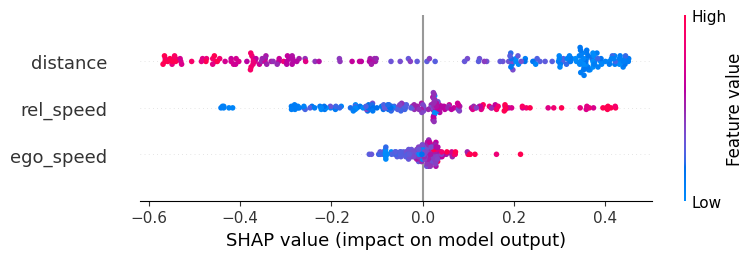

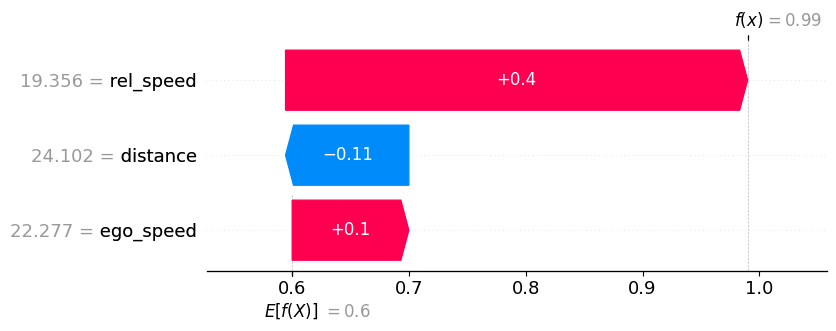

In [ ]:
import shap

print("=== SHAP Explanations: Classification (RF Classifier) ===")

explainer_clf = shap.Explainer(class_models['RF'], Xc_train)
shap_values_clf = explainer_clf(Xc_test)   # shape: (n_samples, n_features, n_classes)

# Global summary (focus on class=1 → Brake)
shap.summary_plot(shap_values_clf[:,:,1], Xc_test, feature_names=Xc_test.columns)

# Local waterfall for one sample (class=1 only)
sample_idx = 0
shap.plots.waterfall(shap_values_clf[sample_idx,:,1])


=== SHAP Explanations: Regression (RF Regressor) ===


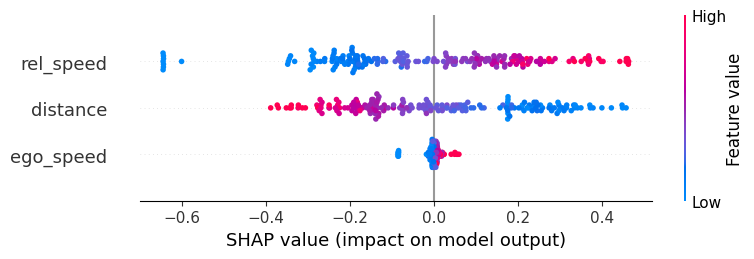

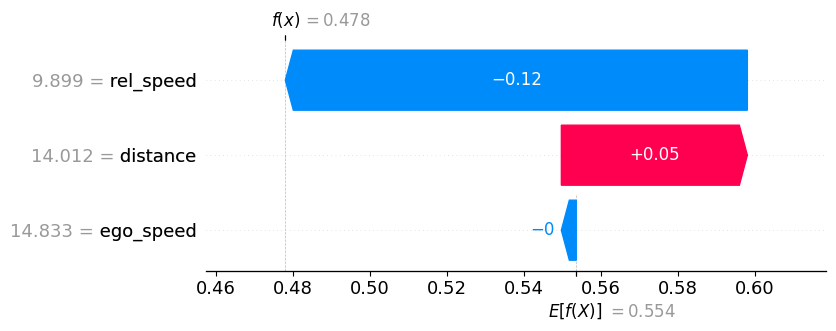

In [ ]:
import shap

print("=== SHAP Explanations: Regression (RF Regressor) ===")

# Use unified Explainer API
explainer_reg = shap.Explainer(reg_models['RF_Reg'], Xr_train)
shap_values_reg = explainer_reg(Xr_test)   # returns an Explanation object

# Global summary plot
shap.summary_plot(shap_values_reg, Xr_test, feature_names=Xr_test.columns)

# Local waterfall for one prediction
sample_idx = 0
shap.plots.waterfall(shap_values_reg[sample_idx])


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 1000
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 50
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/

✅ Saved raw driving GIF: scene.gif
✅ Saved prediction GIF: scene_pred.gif


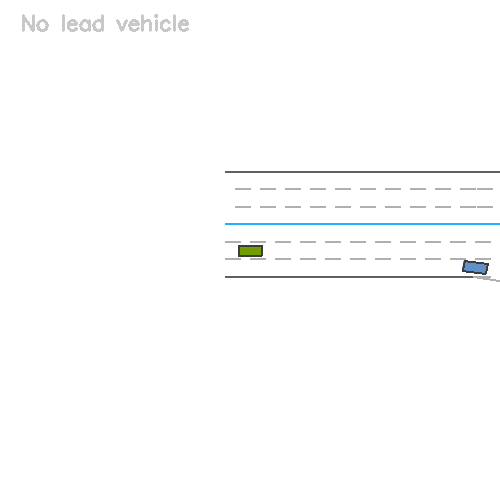

In [ ]:
from metadrive.engine.engine_utils import close_engine
close_engine()

import os
os.environ['SDL_VIDEODRIVER'] = 'dummy'

from metadrive import MetaDriveEnv
from IPython.display import Image as IPyImage
import cv2
import numpy as np
import joblib
import imageio

# Load models
rf_class = class_models['RF']
rf_reg   = reg_models['RF_Reg']

# --- Config ---
config = {
    "use_render": False,
    "accident_prob": 0.5,
    "traffic_density": 0.25,
    "num_scenarios": 50
}
env = MetaDriveEnv(config)

def run_episode_with_predictions(env, ep_idx=0, steps=150,
                                 raw_gif="scene.gif", pred_gif="scene_pred.gif"):
    obs, info = env.reset(seed=ep_idx)
    frames, preds = [], []

    for step in range(steps):
        # ------------------------------
        # Feature extraction
        # ------------------------------
        ego = env.agent
        ego_speed = np.linalg.norm(ego.speed)
        ego_pos   = ego.position
        ego_lane  = ego.lane_index

        min_dist, lead_speed = np.inf, 0.0
        for v in env.engine.traffic_manager.vehicles:
            if v.id == ego.id:
                continue
            if v.lane_index != ego_lane:
                continue
            dx, dy = v.position - ego_pos
            if dx > 0:  # vehicle ahead
                dist = np.linalg.norm([dx, dy])
                if dist < min_dist:
                    min_dist = dist
                    lead_speed = np.linalg.norm(v.speed)

        # ------------------------------
        # Prediction & Closed-loop Action
        # ------------------------------
        if min_dist < np.inf:
            rel_speed = ego_speed - lead_speed
            X = np.array([[ego_speed, rel_speed, min_dist]])
            pred_flag = rf_class.predict(X)[0]   # brake vs safe
            pred_val  = float(rf_reg.predict(X)[0])  # brake intensity (0-1)

            if pred_flag == 1:   # BRAKE
                action = [0.0, 0.0, np.clip(pred_val, 0, 1)]
            else:                # SAFE → keep throttle
                action = [0.0, 0.8, 0.0]

            preds.append((pred_flag, pred_val, min_dist, ego_speed))
        else:
            # No lead car → keep going
            action = [0.0, 0.8, 0.0]
            preds.append((None, None, None, ego_speed))

        # Step simulation
        obs, reward, terminated, truncated, info = env.step(action)

        # Render frame
        frame = env.render(mode="top_down", screen_size=(500, 500), screen_record=True)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)

        if terminated or truncated:
            break

    # ------------------------------
    # Save raw driving GIF
    # ------------------------------
    env.top_down_renderer.generate_gif(raw_gif)

    # ------------------------------
    # Save annotated prediction GIF
    # ------------------------------
    annotated_frames = []
    for i, frame in enumerate(frames):
        overlay = frame.copy()
        pred_flag, pred_val, dist, ego_speed = preds[i]

        if pred_flag is not None:
            status = "BRAKE" if pred_flag == 1 else "SAFE"
            color  = (255, 0, 0) if pred_flag == 1 else (0, 255, 0)
            cv2.putText(overlay, f"{status} | Brake={pred_val:.2f}", (20, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            cv2.putText(overlay, f"Dist={dist:.1f} | Ego={ego_speed:.1f}", (20, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        else:
            cv2.putText(overlay, "No lead vehicle", (20, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200, 200, 200), 2)

        annotated_frames.append(overlay)

    imageio.mimsave(pred_gif, annotated_frames, fps=10)

    print(f"✅ Saved raw driving GIF: {raw_gif}")
    print(f"✅ Saved prediction GIF: {pred_gif}")
    return raw_gif, pred_gif

# Run closed-loop simulation
raw_gif, pred_gif = run_episode_with_predictions(env, ep_idx=40)

# Display annotated prediction GIF
IPyImage(open(pred_gif, "rb").read())


In [ ]:

import gradio as gr
import numpy as np
import joblib, os
from PIL import Image, ImageDraw, ImageFont
import imageio

# Try to load trained models if available
rf_class, rf_reg = None, None
if os.path.exists("rf_class.pkl") and os.path.exists("rf_reg.pkl"):
    rf_class = joblib.load("rf_class.pkl")
    rf_reg = joblib.load("rf_reg.pkl")
    print("✅ Loaded trained models.")
else:
    print("⚠️ Models not found, will use TTC/distance rule fallback.")

def aeb_demo(ego_speed, rel_speed, distance):
    # lead speed (assumed constant for simplicity)
    lead_speed = ego_speed - rel_speed
    dt, steps = 0.1, 150
    ego_x, lead_x = 10.0, 10.0 + distance
    frames = []

    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 16)
    except:
        font = ImageFont.load_default()

    for t in range(steps):
        dist = max(0.0, lead_x - ego_x)
        rel_now = ego_speed - lead_speed
        X = np.array([[ego_speed, rel_now, dist]])

        # --- Prediction (ML model or fallback rule) ---
        if rf_class and rf_reg:
            try:
                flag = int(rf_class.predict(X)[0])
                val = float(rf_reg.predict(X)[0])
            except:
                flag = int((dist < 10) or ((rel_now > 0) and (dist/rel_now < 2)))
                val = min(1.0, (max(0, rel_now)**2) / (2*max(1e-3, dist)) / 6.8)
        else:
            flag = int((dist < 10) or ((rel_now > 0) and (dist/rel_now < 2)))
            val = min(1.0, (max(0, rel_now)**2) / (2*max(1e-3, dist)) / 6.8)

        # --- Closed-loop ego vehicle update ---
        if flag == 1:  # Brake predicted
            decel = val * 6.8  # max decel ≈ 6.8 m/s²
            ego_speed = max(0.0, ego_speed - decel * dt)

        # Update positions
        ego_x += ego_speed * dt
        lead_x += lead_speed * dt

        # --- Draw frame ---
        W, H = 640, 160
        img = Image.new("RGB", (W, H), (30, 30, 30))
        draw = ImageDraw.Draw(img)
        draw.rectangle([0, H//3, W, 2*H//3], fill=(50, 50, 50))
        for x in range(0, W, 40):
            draw.line([(x, H//2), (x+20, H//2)], fill=(200,200,200), width=2)

        world_to_img = lambda wx: int((W*0.2) + (wx - ego_x) * 5.0)
        ego_img_x, lead_img_x = world_to_img(ego_x), world_to_img(lead_x)

        draw.rectangle([ego_img_x-12, H//2-18, ego_img_x+12, H//2+18], fill=(0,120,255))
        color = (255,0,0) if flag == 1 else (0,200,0)
        draw.rectangle([lead_img_x-12, H//2-18, lead_img_x+12, H//2+18], fill=color)

        draw.text((10,10), f"Dist: {dist:.1f} m", fill=(255,255,255), font=font)
        draw.text((10,30), f"Ego speed: {ego_speed:.1f} m/s", fill=(255,255,255), font=font)
        draw.text((10,50), f"Rel speed: {rel_now:.1f} m/s", fill=(255,255,255), font=font)
        draw.text((10,70), f"Pred: {'BRAKE' if flag else 'SAFE'}", fill=color, font=font)
        draw.text((10,90), f"Brake val: {val:.2f}", fill=(255,255,255), font=font)

        frames.append(np.array(img))

        # End if collision
        if dist <= 0:
            break

    # Save GIF
    gif_path = "aeb_demo.gif"
    imageio.mimsave(gif_path, frames, fps=10)
    return gif_path


# Build Gradio UI
demo = gr.Interface(
    fn=aeb_demo,
    inputs=[
        gr.Slider(0, 50, value=15, label="Ego Speed (m/s)"),
        gr.Slider(-30, 30, value=-5, label="Relative Speed (ego - lead) (m/s)"),
        gr.Slider(1, 100, value=25, label="Distance to Lead Vehicle (m)")
    ],
    outputs=gr.Image(type="filepath", label="AEB Simulation"),
    title="🚗 Automatic Emergency Braking Demo",
    description="Adjust parameters and watch the ego & lead vehicles interact with ML-based AEB prediction."
)

demo.launch()


✅ Loaded trained models.
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f79e10be94d95d0d57.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
